## Import Library

In [1]:
import awswrangler as wr
import pandas as pd
from contextlib import suppress
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime
import matplotlib.pyplot as plt

## 데이터 추가 제공 / 층 지정 필요 / 난방 가동 일자(보일러)

In [2]:
## 그래프 한글 출력
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
mpl.rc('font', family=font_name)
mpl.font_manager._rebuild()

## Combine DataFrame

In [4]:
# df = pd.DataFrame()
# for sheet in pd.ExcelFile('s3://poc-ktestate/data/raw_data/3_남수원빌딩 관제점 데이터(2020.01.01_2022.12.31).xlsx').sheet_names:
#     df = pd.concat([df, wr.s3.read_excel('s3://poc-ktestate/data/raw_data/3_남수원빌딩 관제점 데이터(2020.01.01_2022.12.31).xlsx', sheet_name = sheet, header = 1)])  
# df.to_csv('s3://poc-ktestate/data/raw_data/20~22_total_data.csv', index= False)

## Load Data

In [5]:
df = wr.s3.read_csv('s3://poc-ktestate/data/raw_data/20~22_total_data.csv')

In [6]:
df.shape

(105216, 84)

In [7]:
df.head()

,시간,AHU04_급기온도,AHU04_댐퍼,AHU04_혼합온도,AHU04_환기온도,AHU05_급기온도,AHU05_댐퍼,AHU05_혼합온도,AHU05_환기온도,AHU06_급기온도,...,FCU_AG_9F_상태3,FCU_BG_1F_상태1,FCU_BG_1F_상태2,FCU_BG_1F_상태3,FCU_BG_2F_상태1,FCU_BG_2F_상태2,FCU_BG_3F_상태,FCU_BG_4F_상태,FCU_BG_5F_상태1,FCU_BG_5F_상태2
0,2020-01-01 00:00,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01 00:15,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-01 00:30,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-01 00:45,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-01 01:00,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Data PreProcessing

In [8]:
## 공조기 데이터 층수 매핑
floor_dir = {'AHU04': 'AHU_B3F',
             'AHU05': 'AHU_1F',
             'AHU06': 'AHU_2F',
             'AHU07': 'AHU_3F',
             'AHU08': 'AHU_4F',
             'AHU09': 'AHU_5F',
             'AHU13': 'AHU_9F'}
new_columns = []
for column in list(df):
    try:
        new_columns.append('_'.join([floor_dir[column.split('_')[0]],column.split('_')[1]]))
    except:
        new_columns.append(column)
df = pd.DataFrame(columns = new_columns, data = df.values)

for col in list(df):
    with suppress(Exception): df[col] = df[col].astype('float')
df['시간'] = pd.to_datetime(df['시간'])
df['월'] = df['시간'].dt.month
df['년'] = df['시간'].dt.year

In [9]:
## 층별 장비 분포 확인
## AHU만 존재 : 'B3F'
## FCU만 존재 : '10F', '6F', '7F', '8F'
## 둘 다 존재 : '1F', '2F', '3F', '4F', '5F', '9F'
## FCU만 있는 층수 제외 후 진행

floor_info = sum([['B3F'], [f'{num}F' for num in range(1,11)]], [])
rm_col = []
for floor in floor_info:
    temp_col = []    
    for column in list(df):
        if (len(column.split('_')) > 1) and (floor == column.split('_')[1]):          
            temp_col.append(column)
        if (len(column.split('_')) > 2) and (floor == column.split('_')[2]):                     
            temp_col.append(column)
    print(f'{floor} floor col num : {len(temp_col)} -> {temp_col}')
    # ###
    # temp = ''
    # for col in temp_col:
    #     temp += f', {col}'
    # print(temp[1:])
    # print(' ')
    # ###
    if list(set([column.split('_')[0] for column in temp_col])) == ['FCU']:
        rm_col.append(temp_col)
df.drop(sum(rm_col, []), axis = 1, inplace = True)

B3F floor col num : 6 -> ['AHU_B3F_급기온도', 'AHU_B3F_댐퍼', 'AHU_B3F_혼합온도', 'AHU_B3F_환기온도', 'AHU_B3F_급기휀상태', 'AHU_B3F_냉난방밸브']
1F floor col num : 11 -> ['AHU_1F_급기온도', 'AHU_1F_댐퍼', 'AHU_1F_혼합온도', 'AHU_1F_환기온도', 'AHU_1F_급기휀상태', 'AHU_1F_냉난방밸브', 'FCU_AG_1F_상태1', 'FCU_AG_1F_상태2', 'FCU_BG_1F_상태1', 'FCU_BG_1F_상태2', 'FCU_BG_1F_상태3']
2F floor col num : 10 -> ['AHU_2F_급기온도', 'AHU_2F_댐퍼', 'AHU_2F_혼합온도', 'AHU_2F_환기온도', 'AHU_2F_급기휀상태', 'AHU_2F_냉난방밸브', 'FCU_AG_2F_상태1', 'FCU_AG_2F_상태2', 'FCU_BG_2F_상태1', 'FCU_BG_2F_상태2']
3F floor col num : 7 -> ['AHU_3F_급기온도', 'AHU_3F_댐퍼', 'AHU_3F_혼합온도', 'AHU_3F_환기온도', 'AHU_3F_급기휀상태', 'AHU_3F_냉난방밸브', 'FCU_BG_3F_상태']
4F floor col num : 10 -> ['AHU_4F_급기온도', 'AHU_4F_댐퍼', 'AHU_4F_혼합온도', 'AHU_4F_환기온도', 'AHU_4F_급기휀상태', 'AHU_4F_냉난방밸브', 'FCU_AG_4F_상태1', 'FCU_AG_4F_상태2', 'FCU_AG_4F_상태3', 'FCU_BG_4F_상태']
5F floor col num : 9 -> ['AHU_5F_급기온도', 'AHU_5F_댐퍼', 'AHU_5F_혼합온도', 'AHU_5F_환기온도', 'AHU_5F_급기휀상태', 'AHU_5F_냉난방밸브', 'FCU_AG_5F_상태', 'FCU_BG_5F_상태1', 'FCU_BG_5F_상태2']
6F floor col n

In [10]:
## 단일값 제거 (모든 층수에서 댐퍼와 냉난방밸브 삭제)
single_col = []
for column in list(df):
    if df[column].nunique() == 1:
        print(column, df[column].unique())
        single_col.append(column)        
df.drop(single_col, inplace = True, axis = 1)

AHU_B3F_댐퍼 [0.]
AHU_1F_댐퍼 [0.]
AHU_2F_댐퍼 [0.]
AHU_3F_댐퍼 [0.]
AHU_4F_댐퍼 [0.]
AHU_5F_댐퍼 [0.]
AHU_9F_댐퍼 [0.]
냉온수기-2 상태 [0.]
AHU_B3F_냉난방밸브 [0.]
AHU_1F_냉난방밸브 [0.]
AHU_2F_냉난방밸브 [0.]
AHU_3F_냉난방밸브 [0.]
AHU_4F_냉난방밸브 [0.]
AHU_5F_냉난방밸브 [0.]
AHU_9F_냉난방밸브 [0.]
FCU_BG_5F_상태2 [0.]


In [11]:
## Split data as floor
floor_list = list(set([col.split('_')[1] for col in list(df) if (len(col.split('_')) > 1) and (col.split('_')[0] == 'AHU')]))
floor_list.sort()

for floor in floor_list:    
    globals()[f'floor_{floor}'] = []
    for column in list(df):
        if (len(column.split('_')) > 1) and (floor == column.split('_')[1]):          
            globals()[f'floor_{floor}'].append(column)
        elif (len(column.split('_')) > 2) and (floor == column.split('_')[2]):                     
            globals()[f'floor_{floor}'].append(column)
        elif (len(set(column.split('_')) & set(floor_list)) == 0):
            globals()[f'floor_{floor}'].append(column)        
    globals()[f'df_{floor}'] = df[globals()[f'floor_{floor}']].copy()    
    print(f"floor {floor} column num : {len(list(globals()[f'df_{floor}']))}")
    print(list(globals()[f'df_{floor}']))

floor 1F column num : 22
['시간', 'AHU_1F_급기온도', 'AHU_1F_혼합온도', 'AHU_1F_환기온도', 'AHU_1F_급기휀상태', 'CH_CHWS온도1', 'CH_CHWS온도2', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '냉온수기 가스량', '냉온수기-1 상태', '경기대표 외기온도', 'CH_HD_RET온도', 'FCU_AG_1F_상태1', 'FCU_AG_1F_상태2', 'FCU_BG_1F_상태1', 'FCU_BG_1F_상태2', 'FCU_BG_1F_상태3', '월', '년']
floor 2F column num : 21
['시간', 'AHU_2F_급기온도', 'AHU_2F_혼합온도', 'AHU_2F_환기온도', 'AHU_2F_급기휀상태', 'CH_CHWS온도1', 'CH_CHWS온도2', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '냉온수기 가스량', '냉온수기-1 상태', '경기대표 외기온도', 'CH_HD_RET온도', 'FCU_AG_2F_상태1', 'FCU_AG_2F_상태2', 'FCU_BG_2F_상태1', 'FCU_BG_2F_상태2', '월', '년']
floor 3F column num : 18
['시간', 'AHU_3F_급기온도', 'AHU_3F_혼합온도', 'AHU_3F_환기온도', 'AHU_3F_급기휀상태', 'CH_CHWS온도1', 'CH_CHWS온도2', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '냉온수기 가스량', '냉온수기-1 상태', '경기대표 외기온도', 'CH_HD_RET온도', 'FCU_BG_3F_상태', '월', '년']
floor 4F column num : 21
['시간', 'AHU_4F_급기온도', 'AHU_4F_혼합온도', 'AHU_4F_환기온도', 'AHU_4F_급기휀상태', 'CH_CHWS온도1', 'CH_CHWS온도2', 'C

### EDA

In [12]:
## 결측치 없음
for floor in floor_list:
    print(f"floor {floor} na num : {globals()[f'df_{floor}'].isna().sum().sum()}")

floor 1F na num : 0
floor 2F na num : 0
floor 3F na num : 0
floor 4F na num : 0
floor 5F na num : 0
floor 9F na num : 0
floor B3F na num : 1


In [13]:
## 3년간 총 가동된 일자 확인
## 가동 일자가 너무 적은 4,5,9,B3 층은 제외
for floor in floor_list:
    print(f"floor {floor}")
    print(f"가동시간 : {round(globals()[f'df_{floor}'][f'AHU_{floor}_급기휀상태'].sum()/60)} 시간")
    print(f"가동일자 : {globals()[f'df_{floor}'][globals()[f'df_{floor}'][f'AHU_{floor}_급기휀상태'] > 0]['시간'].astype(str).str.split(' ', expand = True)[0].drop_duplicates().shape[0]} 일")
    
eda_floor = [floor for floor in floor_list if floor not in ['4F','5F','9F','B3F']]
eda_floor

floor 1F
가동시간 : 3075 시간
가동일자 : 380 일
floor 2F
가동시간 : 1488 시간
가동일자 : 228 일
floor 3F
가동시간 : 3250 시간
가동일자 : 385 일
floor 4F
가동시간 : 319 시간
가동일자 : 66 일
floor 5F
가동시간 : 18 시간
가동일자 : 4 일
floor 9F
가동시간 : 18 시간
가동일자 : 4 일
floor B3F
가동시간 : 22 시간
가동일자 : 19 일


['1F', '2F', '3F']

Max value : 29.87, Min value : 0.0, Average : 18.334451984488, Variance : 53.252829797550056


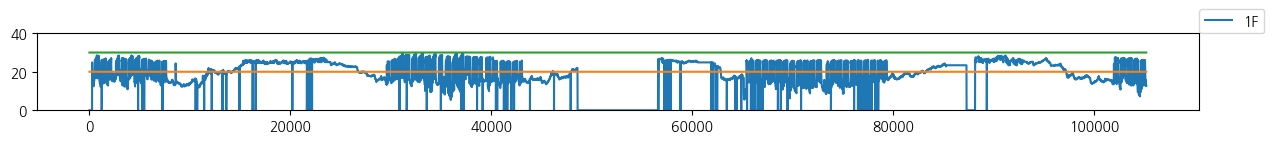

Max value : 28.2647, Min value : 0.0, Average : 17.90158100098379, Variance : 50.24365197090571


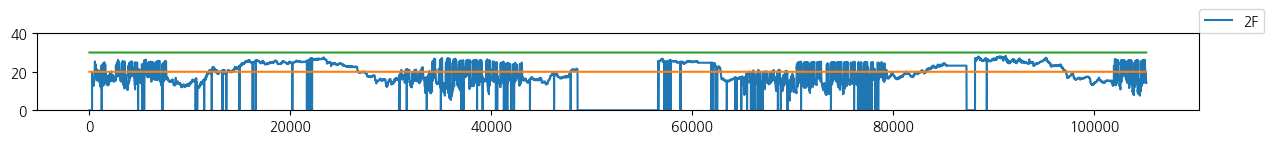

Max value : 30.3, Min value : -4.85, Average : 18.282139091015534, Variance : 63.88574022195841


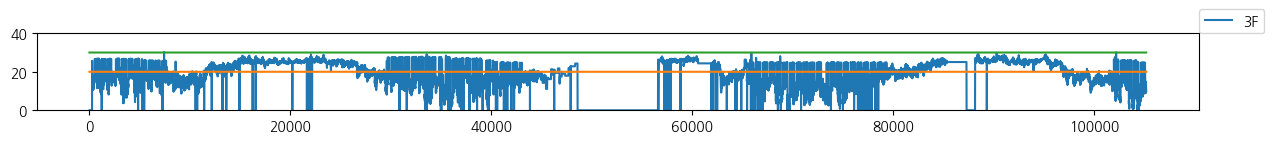

In [14]:
## AHU 컬럼별 추세 확인
## 급기온도(40,50,60) : 각 층별로 증/감 추세는 비슷하지만 최대/최소 값의 차이가 존재 - 층별로 도달하는 물의 온도가 다르기 때문 아닐까? (eda floor 대상으로는 대부분 비슷함)
## 혼합온도(40,35,50) : 각 층별 전반적인 추세는 비슷하지만, 특정 층/시기에 갑자기 상승하는 이상치 존재 - 혼합온도를 모델링에 포함할지에 대한 유무?
## 환기온도(20,30,40) : B3F의 경우 21년 하반기까지 특정 값 이상으로 상승하지 않음 - 일정한 시점이 목표온도에 해당? (eda floor 대상으로는 특이사항 없음)

target_col = '환기온도'
line_1 = 20
line_2 = 30
max_y = 40
    
for floor in eda_floor:
    temp_df = globals()[f'df_{floor}'].copy()
    print(f"Max value : {temp_df[f'AHU_{floor}_{target_col}'].max()}, Min value : {temp_df[f'AHU_{floor}_{target_col}'].min()}, Average : {temp_df[f'AHU_{floor}_{target_col}'].mean()}, Variance : {temp_df[f'AHU_{floor}_{target_col}'].var()}")
    # print(temp_df[temp_df[f'AHU_{floor}_{target_col}']>30][f'AHU_{floor}_{target_col}'].mean())
    plt.figure(figsize=(15,1))
    plt.plot(temp_df[f'AHU_{floor}_{target_col}'])
    plt.plot([line_1 for i in range(len(temp_df))])
    plt.plot([line_2 for i in range(len(temp_df))])
    plt.ylim(0, max_y)
    plt.legend([floor], loc=(1.0, 1.0))
    plt.show()

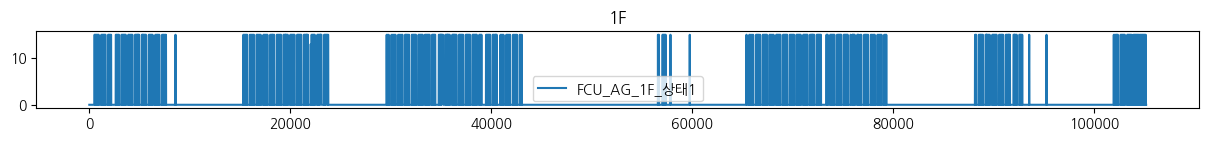

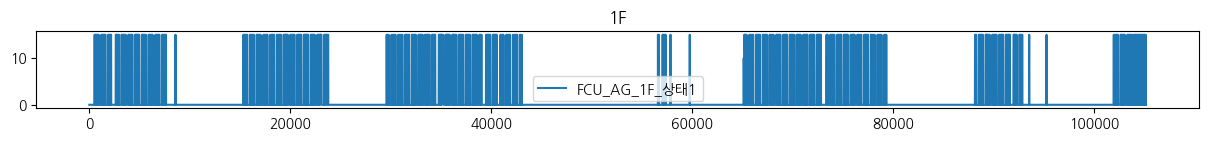

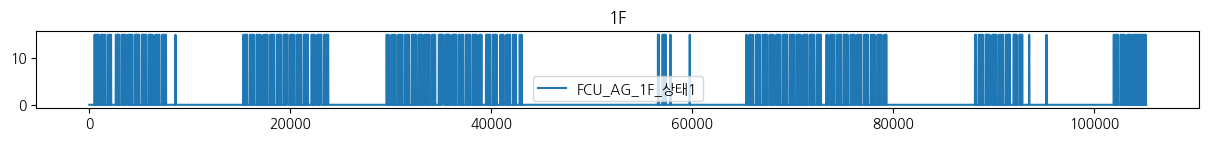

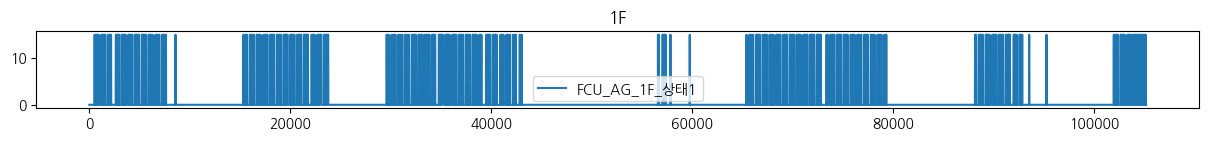

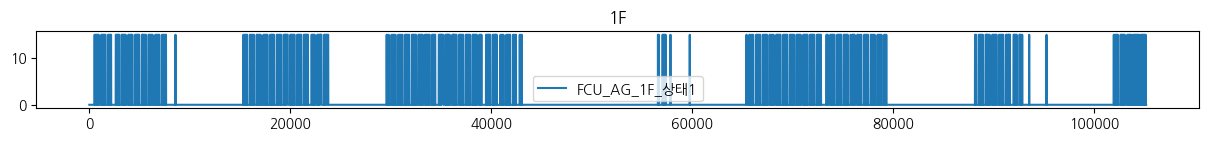

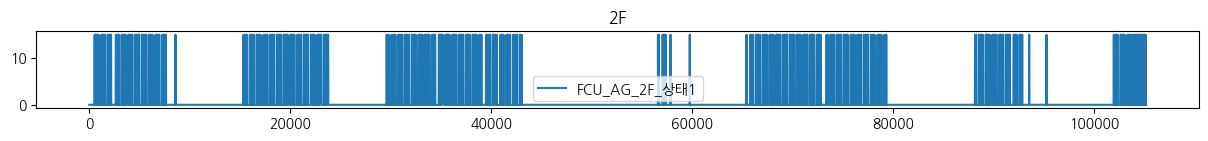

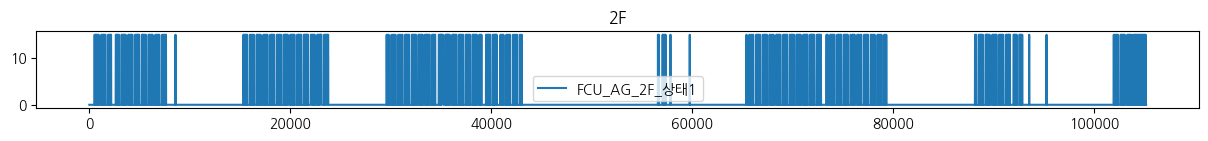

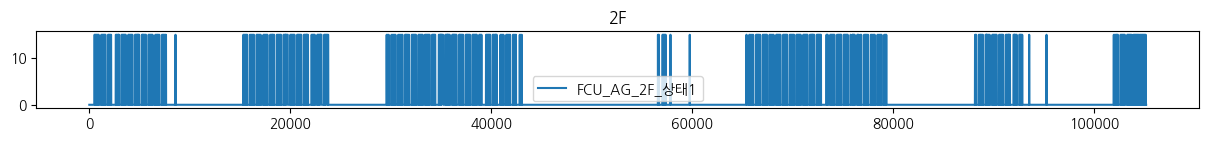

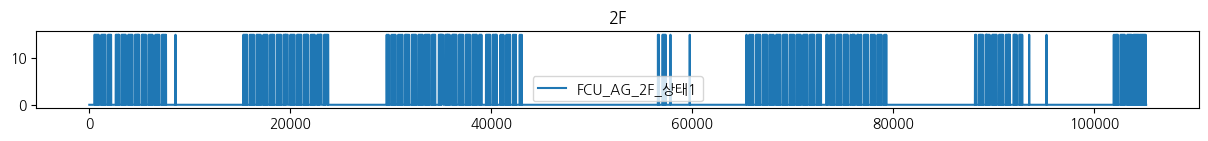

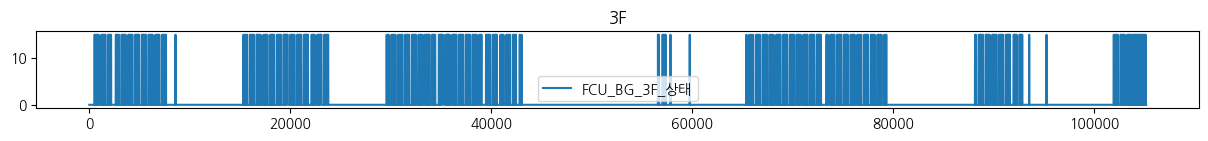

In [15]:
## FCU 컬럼별 추세 확인
## 전체 데이터에 대한 추세가 비슷하며, 각 층마다의 FCU상태가 거의 같음 (상관관계 확인 필요)
target_col = 'FCU'

for floor in eda_floor:
    temp_df = globals()[f'df_{floor}'].copy()
    # plt.figure(figsize=(15,1))
    col_list = []
    for col in list(temp_df):                
        if target_col in col:            
            col_list.append(col)
            # print(f'Floor {floor} {col} column info')
            # print(f"Max value : {temp_df[col].max()}, Min value : {temp_df[col].min()}, Average : {temp_df[col].mean()}, Variance : {temp_df[col].var()}")
            # print("")
            plt.figure(figsize=(15,1))
            plt.plot(temp_df[col])
            plt.legend(col_list)
            plt.title(floor)
            plt.show()

CH_CHWS온도1 values -> max : 60.8307, mean : 26.090095816231415, min : 0.0


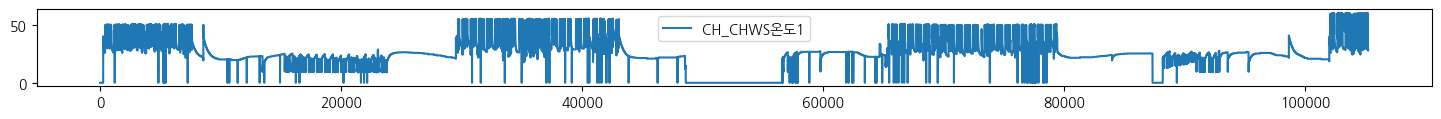

CH_CHWS온도2 values -> max : 54.566, mean : 25.76297122015906, min : 0.0


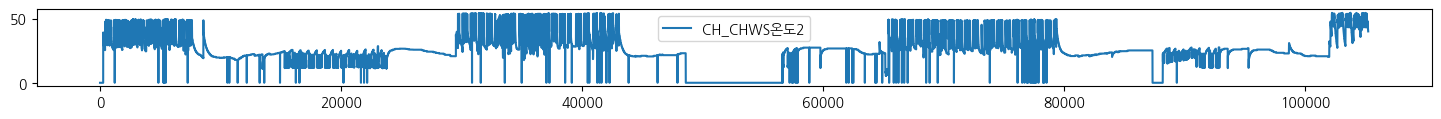

CH_CWR온도1 values -> max : 33.8353, mean : 21.786723990645168, min : 0.0


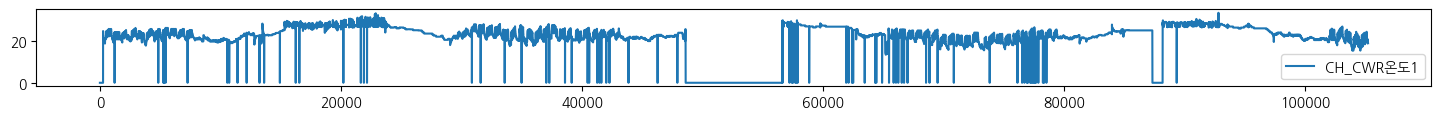

CH_CWR온도2 values -> max : 35.356, mean : 21.992291206669357, min : 0.0


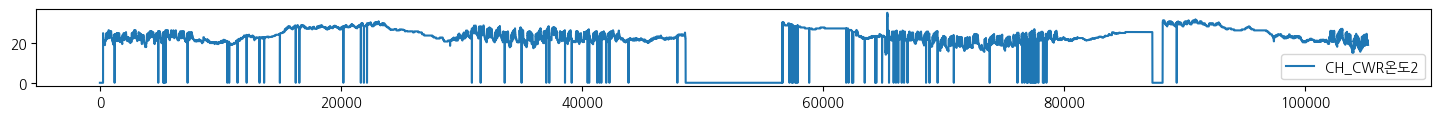

CH_CWS온도1 values -> max : 61.4373, mean : 22.2067136842357, min : 0.0


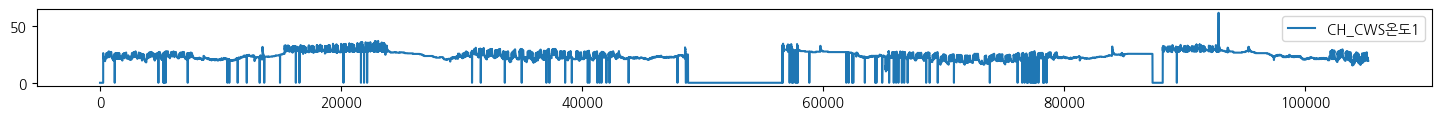

CH_CWS온도2 values -> max : 34.558, mean : 22.041166889058733, min : 0.0


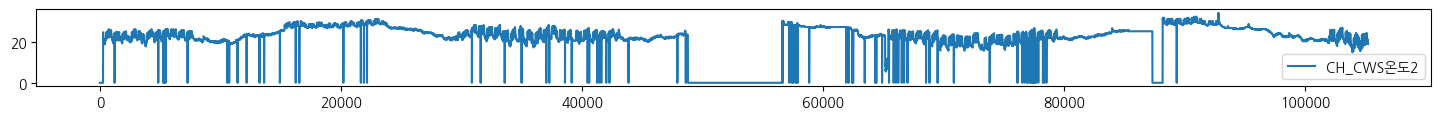

냉온수기 가스량 values -> max : 606571.0, mean : 209376.18559281097, min : 0.0


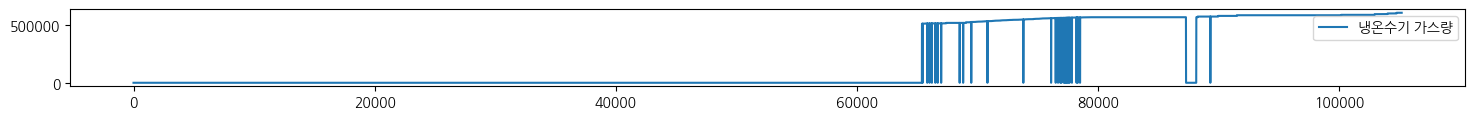

냉온수기-1 상태 values -> max : 15.0, mean : 0.1673414689781022, min : 0.0


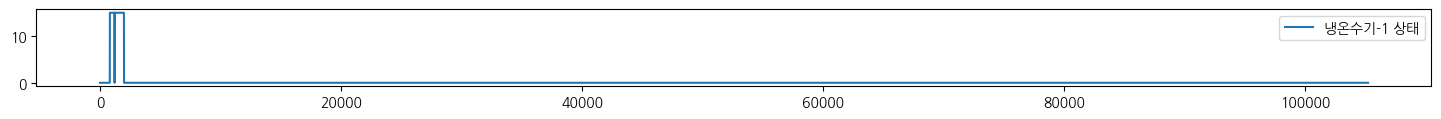

경기대표 외기온도 values -> max : 36.3, mean : 13.187273472665611, min : -18.5733


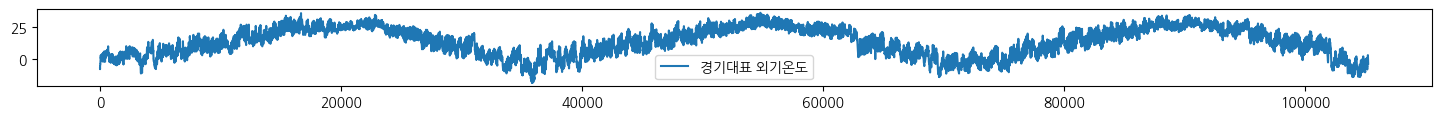

CH_HD_RET온도 values -> max : 59.86, mean : 24.250107439931927, min : 0.0


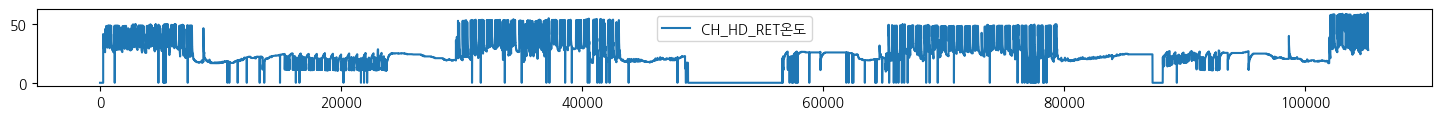

In [16]:
## 층별 공통 컬럼 추세 확인
## CH_CHWS 온도 1/2 유사
## CH_CWR 온도 1/2 유사
## CH_CWS 온도 1/2 유사
## 냉온수기 가스량과 냉온수기-1상태의 경우 3년간의 데이터 추세가 일정하지 않기 때문에 제외 (0인 값이 너무 많음)
## 경기대표 외기온도의 경우 특정값에 멈춰있거나, 값이 제대로 측정되지 않은 시점 존재 (사용여부 고려 필요)
for col in list(df):
    if col.split('_')[0] not in ['AHU', 'FCU', '시간','월','년']:      
        plt.figure(figsize=(18,1))       
        print(f'{col} values -> max : {df[col].max()}, mean : {df[col].mean()}, min : {df[col].min()}')  
        plt.plot(df[col])        
        plt.legend([col])        
        plt.show()

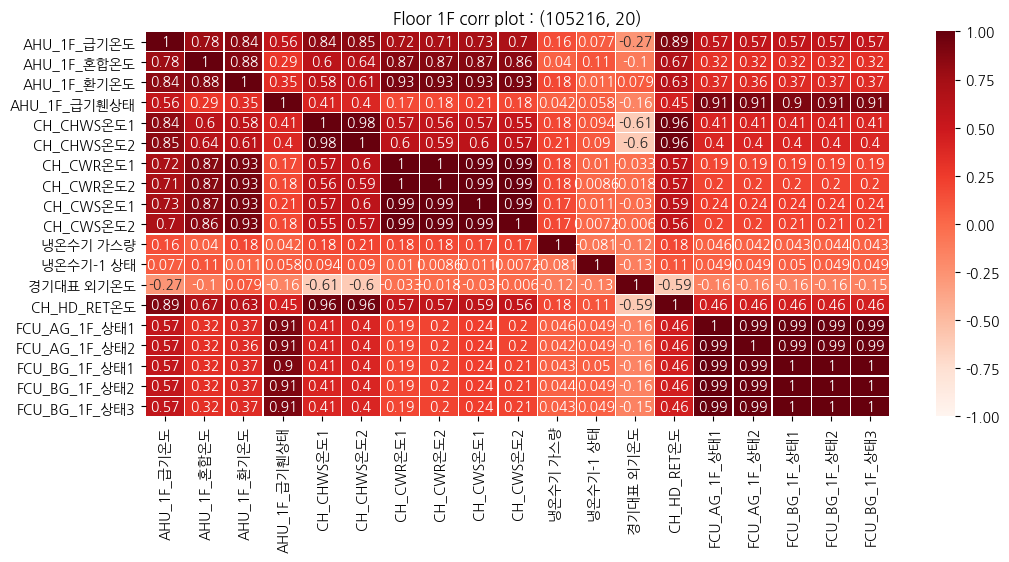

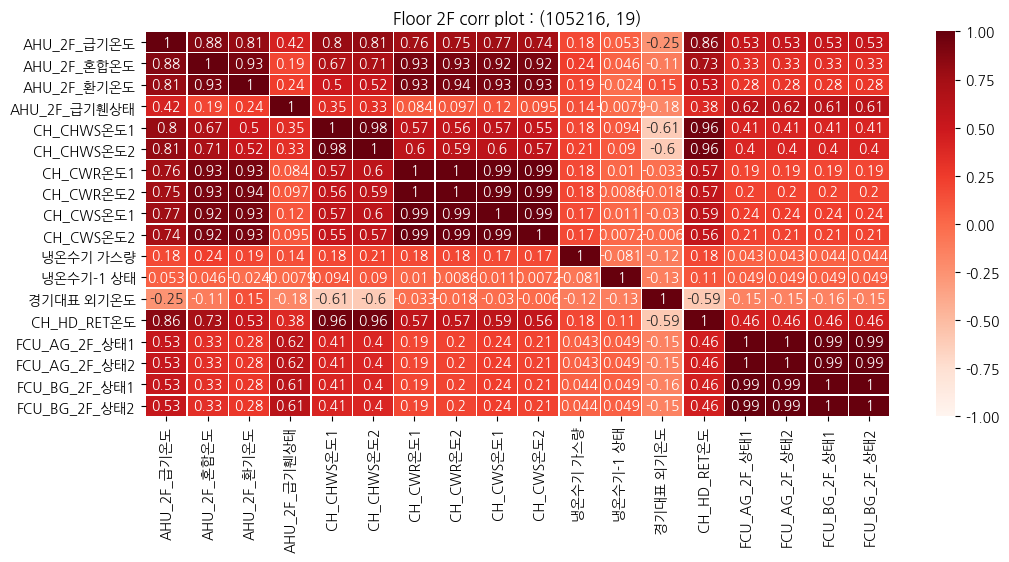

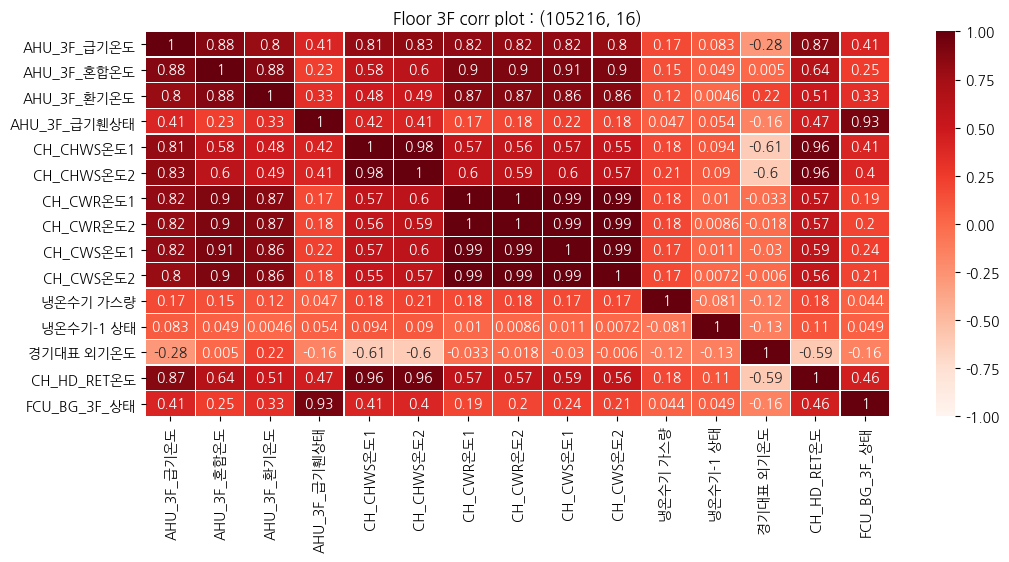

In [17]:
## 상관분석 그래프 출력
## 전체 데이터 : 공조기가 가동중이지 않을 때 관련 값들이 모두 0이 나오기 때문에 유의미한 결과라고 판단할 수 없음
import seaborn as sns

for floor in eda_floor:
    plt.figure(figsize=(12,5))
    temp_df = globals()[f'df_{floor}'].copy()
    temp_df.drop(['년','월'], axis = 1, inplace = True)
    sns.heatmap(temp_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='Reds')
    plt.title(f"Floor {floor} corr plot : {temp_df.shape}")
    plt.show()    

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


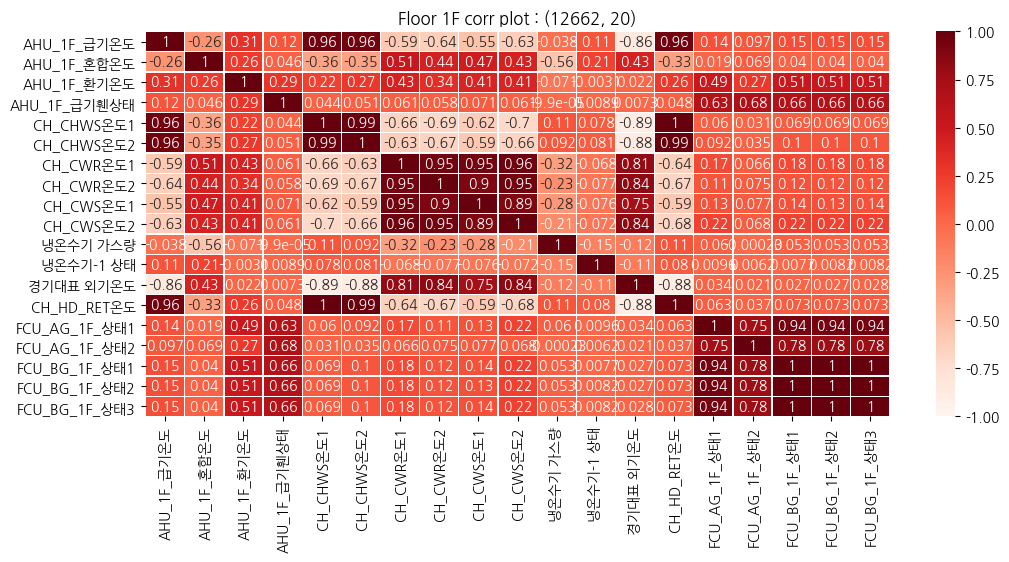

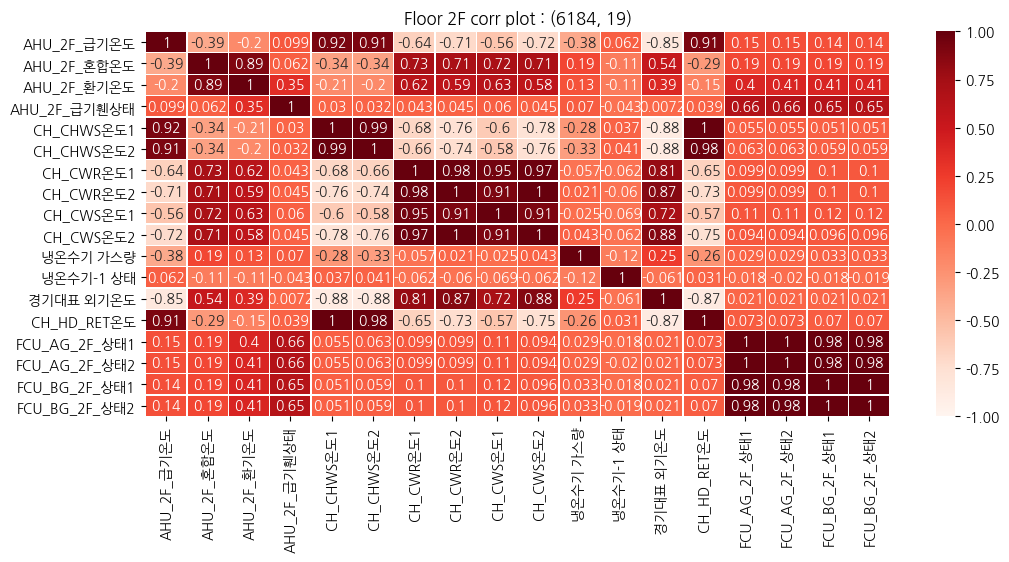

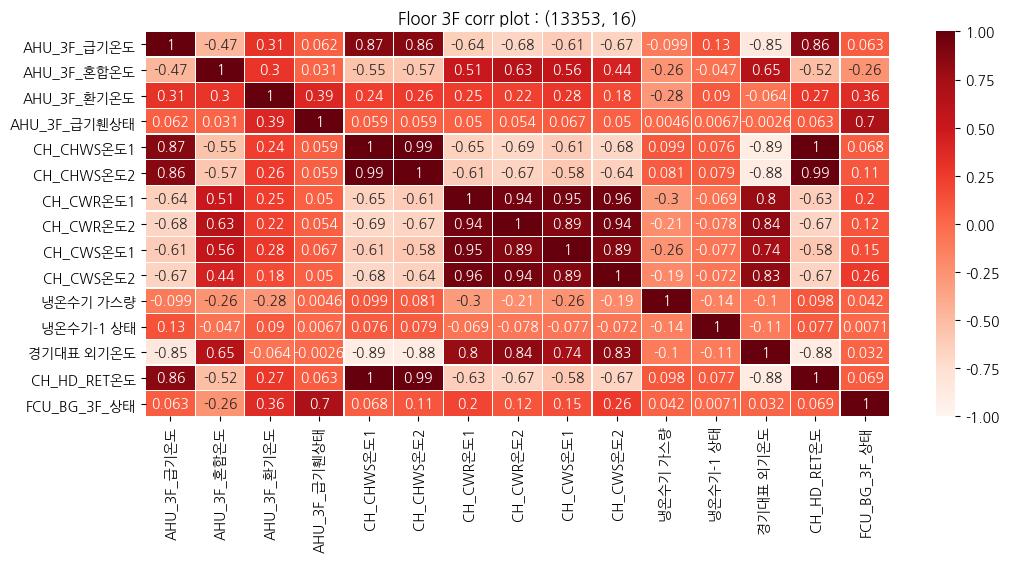

In [18]:
## 상관분석 그래프 출력
## 공조기 가동중 필터링
## : 급기온도와 냉각수온도(ch_chws)의 상관관계가 높음 (동절기인데 왜?.. 데이터정의서에는 안그럼)
## : 급기온도, 냉각수온도(ch_chws)와 외부온도의 역 상관관계 (밖이 추울수록 따뜻하게 트니까..)
## : 외부온도와 환수/공급온도(cwr/cws) 온도의 상관관계가 높음 (어째서?? 밖이 추우면 공급온도가 높아야하는데.. 더 낮다?)
## : 냉각수온도(ch_chws)와 환수온도(ch_cwr)의 역 상관관계 (어째서??)
## : FCU와 급기휀상태는 비례관계 (난방을 위해서 둘다 트니까..)
## : 상관관계가 너무 높은 컬럼에 대해서는 제거 or 축소 필요 (ex_ CH_CHWS중 1개/CWR과 CWS중 1개만 사용)

for floor in eda_floor:
    plt.figure(figsize=(12,5))
    temp_df = globals()[f'df_{floor}'][globals()[f'df_{floor}'][f'AHU_{floor}_급기휀상태']>0]
    temp_df.drop(['년','월'], axis = 1, inplace = True)
    sns.heatmap(temp_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='Reds')
    plt.title(f"Floor {floor} corr plot : {temp_df.shape}")
    plt.show()    

## Make Training Data

In [54]:
target_floor = '1F'

data = globals()[f'df_{target_floor}'].copy()
data.drop(['월','년'], axis = 1, inplace = True)
train_df = data[data['시간'] < '2022-12-01'].copy()

train_df = train_df[train_df[f'AHU_{target_floor}_급기휀상태'] > 0]
train_df['시간'] = pd.to_datetime(train_df['시간'])
train_df['날짜'] = pd.to_datetime(train_df['시간']).dt.normalize()
# temp_df['월'] = pd.to_datetime(temp_df['시간']).dt.month

In [55]:
## 중간 내용 고려한 데이터 생성
# total_df = train_df.copy()
total_df = pd.DataFrame()
add_num_range = 40

for date in train_df['날짜'].unique():
    print(f'date : {date}')
    temp_df = train_df[train_df['날짜'] == date].copy()  ## 날짜별 필터링
    temp_df.reset_index(drop = True, inplace = True)
    for num in range(add_num_range):  
        if num%10 == 0:
            print(f'number {num}')
        add_num = num + 1
        for index in temp_df.index:  
            if index <= temp_df.index.max() - add_num:
                temp_value = 0
                for num in range(add_num):
                    temp_value += temp_df.loc[index + num + 1,f'AHU_{target_floor}_급기휀상태']
                temp_df.loc[index, 'operation_time'] = temp_value
                temp_df.loc[index, 'target_temp'] = temp_df.loc[index+add_num,f'AHU_{target_floor}_환기온도']
        total_df = pd.concat([total_df, temp_df])
total_df.drop_duplicates(inplace = True)
total_df.dropna(axis = 0, inplace = True)
many_df = total_df.copy()

date : 2020-01-06T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-07T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-08T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-09T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-10T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-13T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-14T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-15T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-16T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-17T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-20T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-21T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-01-22T00:00:00.000000000
number 0
number 10
number 20
number 30
date : 2020-

In [56]:
print(many_df.shape)
many_df.to_csv("train_data.csv")

(218480, 23)


## Make Test Data

In [57]:
## 1일 기준 시작/끝 데이터 생성
test_df = data[data['시간'] >= '2022-12-01'].copy()
test_df = test_df[test_df[f'AHU_{target_floor}_급기휀상태'] > 0]
test_df['시간'] = pd.to_datetime(test_df['시간'])
test_df['날짜'] = pd.to_datetime(test_df['시간']).dt.normalize()

temper = test_df[test_df['시간'].isin(test_df.groupby(['날짜'])[['시간']].max()['시간'])][['날짜',f'AHU_{target_floor}_환기온도']].copy()
temper.rename(columns = {f'AHU_{target_floor}_환기온도' : 'target_temp'}, inplace = True)
target = test_df.groupby(['날짜'])[f'AHU_{target_floor}_급기휀상태'].sum().reset_index()
target.rename(columns = {f'AHU_{target_floor}_급기휀상태' : 'operation_time'}, inplace = True)
input_time = test_df.groupby(['날짜'])['시간'].min().reset_index()[['시간']]
model_df = test_df[test_df['시간'].isin(input_time['시간'])].copy()
model_df = pd.merge(model_df, temper, on = '날짜', how = 'left')
model_df = pd.merge(model_df, target, on = '날짜', how = 'left')
mini_df = model_df.copy()

## Model Test

In [58]:
train_df = many_df.copy()
test_df = mini_df.copy()

train_df.drop(['시간','날짜'], axis = 1, inplace = True)
test_df.drop(['시간','날짜'], axis = 1, inplace = True)

feature_list = list(train_df)
feature_list.remove('operation_time')
train_x = train_df[feature_list]
train_y = train_df[['operation_time']]

test_x = test_df[feature_list]
test_y = test_df[['operation_time']]

model = RandomForestRegressor(random_state=1004).fit(train_x, train_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [59]:
print(np.sqrt(mean_squared_error(train_y, model.predict(train_x))))

62.47074119703923


In [60]:
print(np.sqrt(mean_squared_error(test_y, model.predict(test_x))))

163.88889445056353


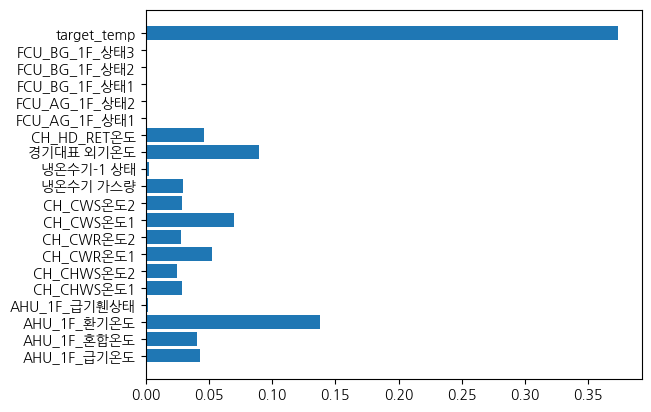

In [61]:
plt.barh(list(train_x), model.feature_importances_)
with suppress(Exception): plt.show()